# What's here

- using conda venv lets_drift_env_V1

- Evaluate the latents and corresponding firing neurons. 


In [1]:
# Import necessary libraries
import pandas as pd
import json
import re
import numpy as np

# Preprocessing: What data is worth looking at? 

The interesting data: the ones where the unsteered answer is correct, but the steered answer IS or IS NOT. 


Each the  contains three JSON objects concatenated together:
1. The first part with metadata and prompt
2. The middle part with answers and activations
3. The final part with evaluation

Some scripting is needed to read it back out.....:

In [2]:
def parse_jsonl_line(file_path, line_number=0):
    """
    Parse a specific line from a JSONL file into a pandas DataFrame.
    
    Args:
        file_path (str): Path to the JSONL file
        line_number (int): Line number to read (0-based index)
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed JSON data
    """
    try:
        # Read the specified line of the JSONL file
        with open(file_path, 'r') as file:
            for i, line in enumerate(file):
                if i == line_number:
                    target_line = line
                    break
            else:
                raise ValueError(f"Line number {line_number} not found in file")

        # Find all JSON objects using regex
        json_pattern = r'{[^}]+}'
        json_matches = re.findall(json_pattern, target_line)

        # Parse each JSON object separately
        data_parts = []
        for json_str in json_matches:
            try:
                data_parts.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Failed to parse JSON part: {e}")
                print(f"Problematic JSON string: {json_str[:100]}...")
                continue

        # Combine all parts into a single dictionary
        combined_data = {}
        for part in data_parts:
            combined_data.update(part)

        # Convert to DataFrame and return
        return pd.DataFrame([combined_data])

    except Exception as e:
        print(f"Error processing data: {e}")
        return None

# Example usage:
# df = parse_jsonl_line('0to60USMLE_pirate.jsonl', line_number=0)
# if df is not None:
#     print(df)

In [3]:
#df = parse_jsonl_line('0to60USMLE_pirate.jsonl', line_number=5)  # Get the 6th line
#if df is not None:
#    print(df)

In [4]:
def get_correct_unsteered_cases(file_path):
    """
    Get all cases where the unsteered answer was correct (evaluation starts with 1)
    using the parse_jsonl_line function.
    
    Args:
        file_path (str): Path to the JSONL file
    
    Returns:
        pandas.DataFrame: DataFrame containing all cases where unsteered answer was correct
    """
    # Initialize an empty DataFrame
    correct_cases = pd.DataFrame()
    
    # Get total number of lines in file
    with open(file_path, 'r') as file:
        num_lines = sum(1 for _ in file)
    
    # Loop through each line
    for line_num in range(num_lines):
        # Try to parse the line
        df = parse_jsonl_line(file_path, line_num)
        
        # Check if evaluation exists and starts with 1
        if df is not None and 'evaluation' in df.columns:
            try:
                eval_str = df['evaluation'].iloc[0]
                first_num = int(eval_str[0])
                if first_num == 1:
                    correct_cases = pd.concat([correct_cases, df], ignore_index=True)
            except Exception as e:
                print(f"Error processing evaluation at line {line_num}: {e}")
                continue
    
    return correct_cases

### CHOOSE FILE NAME TO EVALUATE
- first, evaluate the file manually using EVAL_steered_jsonl.ipynb to add the 'evaluation' column to the jsonl

In [5]:
file_name= "0to60USMLE_pirate.jsonl"

In [6]:
correct_df = get_correct_unsteered_cases(file_name)
print(f"Found {len(correct_df)} cases with correct unsteered answers")


Found 37 cases with correct unsteered answers


In [7]:
#correct_df.head()
print("\nColumns in correct_df:")
print(correct_df.columns)



Columns in correct_df:
Index(['Dataset', 'Prompt_ID', 'Model', 'SAE_release', 'SAE_ID',
       'Steered_Latent_ID', 'Steering_coefficient', 'Prompt', 'Ref_answer',
       'Temperature', 'Frequency_penalty', 'Verbose',
       'Incremental_temperature', 'Comment', 'Answer_No_Steering',
       'SAE_Activations_No_Steering', 'Top_Activations_No_Steering',
       'Answer_Steered0', 'SAE_Activations_Steered0',
       'Top_Activations_Steered0', 'Answer_Steered1',
       'SAE_Activations_Steered1', 'Top_Activations_Steered1', 'evaluation'],
      dtype='object')


# IDEAS: Different approaches to detect the DRIFT
- 3 types of vector similarity https://www.pinecone.io/learn/vector-similarity/ or https://medium.com/advanced-deep-learning/understanding-vector-similarity-b9c10f7506de
    - can be calculated for:
        - Top Latents vector
        - All SAE.Activations  vector
        - All Neurons vector --> DID NOT RECORD THEM SO FAR!
- Another idea may be to use a classifier (needs a decent amount of labeled data!) 
    - It will probably just figure out that if you look at the 'steered latent' you have a good chance of figuring out where the mistaken answers are..

**Plot Eval:**

*Better for individual prompts:*

- Bar Graph: Top active latents of correct answer together with top active latents of non-correct and correct steered answers (different colours)
- Bar Graph: Top active latents of correct answer together with the same latents of non-correct and correct steered (different colours) answers
--> Already wrote some code for this: LetsDriftGemma2_Hooked_continued (or _tutorial? not sure)

*For individual prompts:*

- Try the script from 3brown1blue for showing high-D vectors in 3D (Top Latents or neurons)
Show drift by showing how the vector moves.

*For a collection of prompts:*

- Could be interesting to add all vectors together of one answer, and then of another answer


#### THOUGHTS after first evals:

- perhaps the code in LetsDriftGemma2_Hooked_Tutorials is interesting --> here there was a code I made that (accidentally) read out the top 5(+) latents of EACH forward pass!

-> right now we're just looking at the latents of the final pass. That's not looking good enuf.

-> Pregunta für Schacht: Datatype for huge amounts of data? (if I also want to store all the neuron and each pass' activations?)



## Manhattan distance
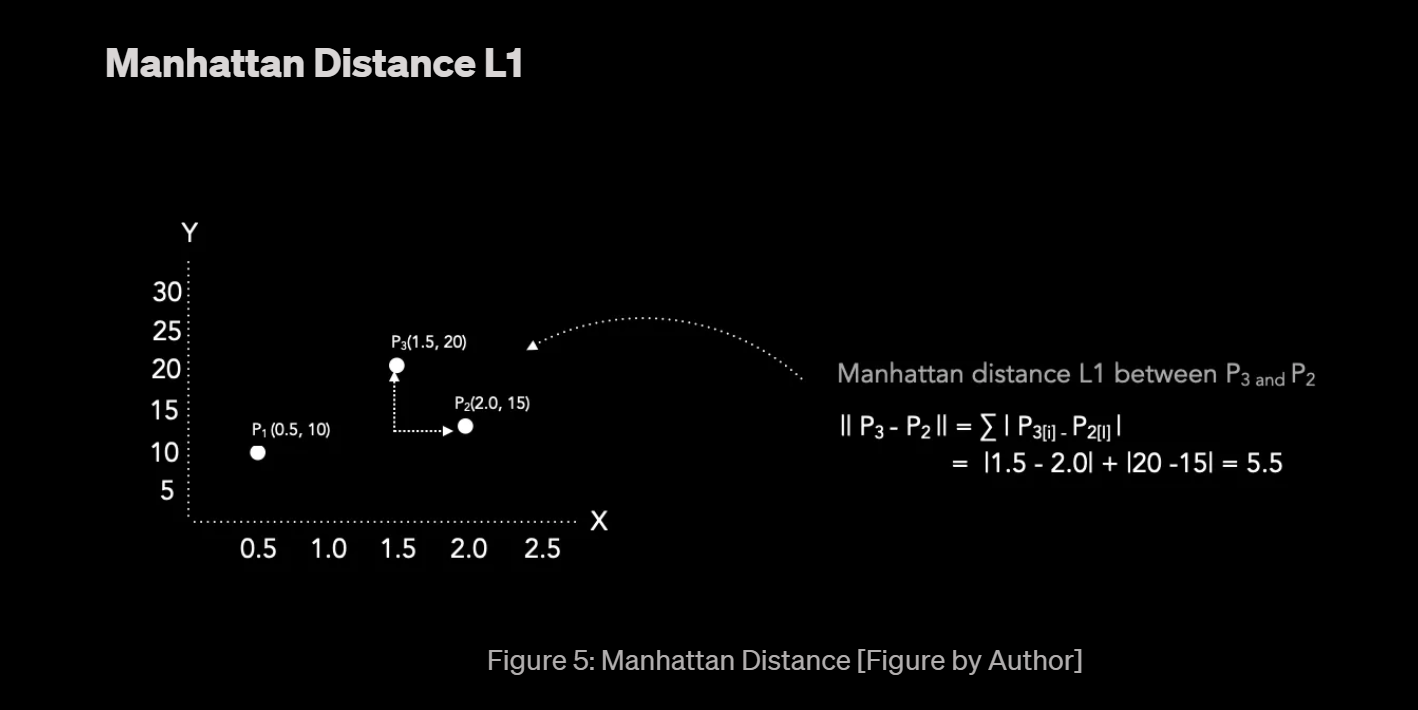

- Calculate the Manhattan distance between unsteered (correct) answer and all steered (correct or uncorrect) answers
- Compare the results for those that are correct and those that arent - Scatter plot

In [8]:
def calculate_manhattan_distance(vec1, vec2, bNormalize=False):
    """
    Calculate Manhattan distance between two vectors, with optional normalization.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] before calculating distance
    
    Returns:
        float: Manhattan distance between the vectors
    """
    # Convert to numpy arrays
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    
    if bNormalize:
        # Normalize vectors to [-1, 1]
        # Avoid division by zero for vec1
        vec1_range = vec1.max() - vec1.min()
        vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1 if vec1_range != 0 else np.zeros_like(vec1)
        
        # Avoid division by zero for vec2  
        vec2_range = vec2.max() - vec2.min()
        vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1 if vec2_range != 0 else np.zeros_like(vec2)
    
    return np.sum(np.abs(vec1 - vec2))



In [9]:
#TODO: this only takes up to 2 steered answers into account - could make it dynamic if needed
# Calculate Manhattan distances for all rows and add as new columns
# For SAE activations
correct_df['manhattan_dist_steered0'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered0']
    ),
    axis=1
)

correct_df['manhattan_dist_steered1'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered1']
    ),
    axis=1
)

# For Top activations
correct_df['manhattan_dist_top_steered0'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered0']
    ),
    axis=1
)

correct_df['manhattan_dist_top_steered1'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered1']
    ),
    axis=1
)

# Print first few results to verify
print("\nFirst few Manhattan distances for SAE activations:")
print(correct_df[['manhattan_dist_steered0', 'manhattan_dist_steered1']].head())
print("\nFirst few Manhattan distances for Top activations:")
print(correct_df[['manhattan_dist_top_steered0', 'manhattan_dist_top_steered1']].head())


First few Manhattan distances for SAE activations:
   manhattan_dist_steered0  manhattan_dist_steered1
0              3772.064097              3465.419723
1              8517.429745              4390.602046
2             15007.050960              3040.118958
3              9497.247185              4410.874979
4              3206.257419             12755.861402

First few Manhattan distances for Top activations:
   manhattan_dist_top_steered0  manhattan_dist_top_steered1
0                658430.623430                505633.466423
1                524659.022503                574446.395208
2                463533.227845                444909.442298
3                703135.710657                501086.213115
4                559220.845979                490232.104349


In [10]:
# Example usage with normalization
# For SAE activations
correct_df['manhattan_dist_steered0_normalized'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered0'],
        bNormalize=True
    ),
    axis=1
)

correct_df['manhattan_dist_steered1_normalized'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered1'],
        bNormalize=True
    ),
    axis=1
)

# For Top activations
correct_df['manhattan_dist_top_steered0_normalized'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered0'],
        bNormalize=True
    ),
    axis=1
)

correct_df['manhattan_dist_top_steered1_normalized'] = correct_df.apply(
    lambda row: calculate_manhattan_distance(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered1'],
        bNormalize=True
    ),
    axis=1
)

# Print first few results to compare normalized vs non-normalized
print("\nFirst few Manhattan distances for SAE activations (normalized vs non-normalized):")
print(correct_df[['manhattan_dist_steered0', 'manhattan_dist_steered0_normalized',
                  'manhattan_dist_steered1', 'manhattan_dist_steered1_normalized']].head())
print("\nFirst few Manhattan distances for Top activations (normalized vs non-normalized):")
print(correct_df[['manhattan_dist_top_steered0', 'manhattan_dist_top_steered0_normalized',
                  'manhattan_dist_top_steered1', 'manhattan_dist_top_steered1_normalized']].head())


First few Manhattan distances for SAE activations (normalized vs non-normalized):
   manhattan_dist_steered0  manhattan_dist_steered0_normalized  \
0              3772.064097                          135.276763   
1              8517.429745                          217.101378   
2             15007.050960                          285.746786   
3              9497.247185                          181.368826   
4              3206.257419                           69.216019   

   manhattan_dist_steered1  manhattan_dist_steered1_normalized  
0              3465.419723                          130.473174  
1              4390.602046                          141.791843  
2              3040.118958                           67.297485  
3              4410.874979                           89.636935  
4             12755.861402                          242.358895  

First few Manhattan distances for Top activations (normalized vs non-normalized):
   manhattan_dist_top_steered0  manhattan_dist_

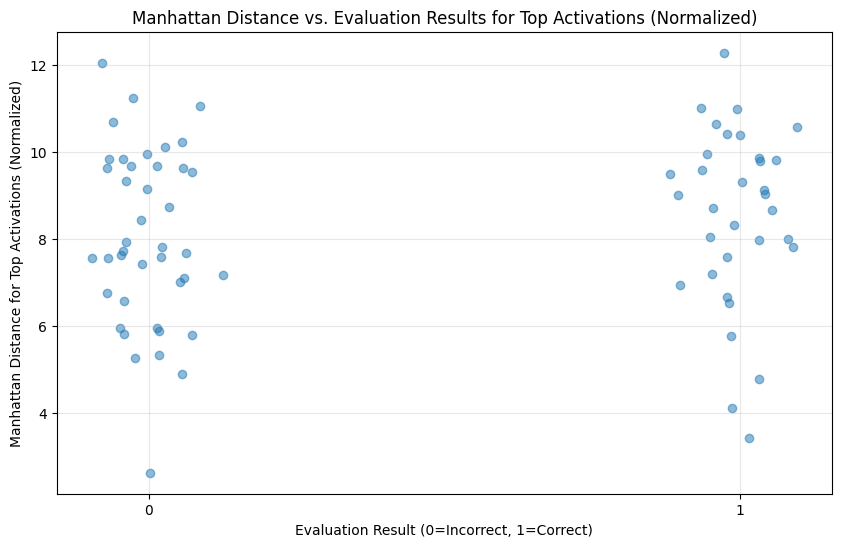

NOTE: There is some jitter to 0 and 1 values applied to better show the distribution


In [11]:
import matplotlib.pyplot as plt
use_normalized = True # USE THE NORMALIZED OR NORMAL MANHATTAN DIST FOR PLOT...:
use_top_activations = True # Whether to use top 10 SAE activations instead of all SAE activations

# Extract evaluation results for steered answers
def get_steered_evaluations(eval_list):
    """Extract evaluation results from the evaluation list"""
    # Return steered results (positions 1 and 2) as integers
    return [int(eval_list[1]), int(eval_list[2])]

# Create lists for plotting
x_values = []  # Will contain 0s and 1s from evaluations
y_values = []  # Will contain corresponding normalized distances

# Process each row
for _, row in correct_df.iterrows():
    steered_evals = get_steered_evaluations(row['evaluation'])
    
    # Add steered0 data point
    x_values.append(steered_evals[0])
    
    # Choose appropriate column names based on settings
    if use_top_activations:
        steered0_col = 'manhattan_dist_top_steered0_normalized' if use_normalized else 'manhattan_dist_top_steered0'
        steered1_col = 'manhattan_dist_top_steered1_normalized' if use_normalized else 'manhattan_dist_top_steered1'
    else:
        steered0_col = 'manhattan_dist_steered0_normalized' if use_normalized else 'manhattan_dist_steered0'
        steered1_col = 'manhattan_dist_steered1_normalized' if use_normalized else 'manhattan_dist_steered1'
    
    y_values.append(row[steered0_col])
    
    # Add steered1 data point
    x_values.append(steered_evals[1])
    y_values.append(row[steered1_col])

# Convert x_values to numpy array of integers
x_values = np.array(x_values, dtype=int)

# Create scatter plot
plt.figure(figsize=(10, 6))

# Add some jitter to x-axis to better show distribution
x_jitter = np.random.normal(0, 0.05, len(x_values))
plt.scatter(x_values + x_jitter, y_values, alpha=0.5)

activation_type = "Top Activations" if use_top_activations else "SAE Activations"
plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
plt.ylabel(f'Manhattan Distance for {activation_type}' + (' (Normalized)' if use_normalized else ''))
plt.title(f'Manhattan Distance vs. Evaluation Results for {activation_type}' + (' (Normalized)' if use_normalized else ''))

# Set x-axis ticks to only show 0 and 1
plt.xticks([0, 1])

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show plot
plt.show()
print("NOTE: There is some jitter to 0 and 1 values applied to better show the distribution")


In [12]:

# Print some basic statistics

print(f"\nStatistics for {file_name}:")
correct_distances = [d for i, d in enumerate(y_values) if x_values[i] == 1]
incorrect_distances = [d for i, d in enumerate(y_values) if x_values[i] == 0]
print(f"Total number of entries in dataset: {len(correct_df)}")
print(f"Number of correct steered answers: {len(correct_distances)}")
print(f"Number of incorrect steered answers: {len(incorrect_distances)}")
print(f"Average distance for steered correct answers: {np.mean(correct_distances):.2f}")
print(f"Average distance for steered incorrect answers: {np.mean(incorrect_distances):.2f}")


Statistics for 0to60USMLE_pirate.jsonl:
Total number of entries in dataset: 37
Number of correct steered answers: 33
Number of incorrect steered answers: 41
Average distance for steered correct answers: 8.54
Average distance for steered incorrect answers: 8.05


##### RESULTS: USMLE Dataset
The 0to60USMLE_pirate shows quite clearly, that the manhattan distance is completely useless (for this dataset)

- **Idea**: Filter out the steered latent...?

Readout:

    Statistics for 0to60USMLE_pirate.jsonl:
    Total number of entries in dataset: 37
    Number of correct steered answers: 33
    Number of incorrect steered answers: 41
    Average distance for steered correct answers: 166.97
    Average distance for steered incorrect answers: 168.88

## Cosine similarity between SAE activations

In [13]:
def calculate_cosine_similarity(vec1, vec2, bNormalize=False):
    """
    Calculate cosine similarity between two vectors, with optional normalization.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] before calculating similarity
    
    Returns:
        float: Cosine similarity between the vectors
    """
    # Convert to numpy arrays and flatten
    vec1 = np.array(vec1).flatten()
    vec2 = np.array(vec2).flatten()
    
    if bNormalize:
        # Normalize vectors to [-1, 1]
        vec1_range = vec1.max() - vec1.min()
        vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1 if vec1_range != 0 else np.zeros_like(vec1)
        
        vec2_range = vec2.max() - vec2.min()
        vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1 if vec2_range != 0 else np.zeros_like(vec2)
    
    # Calculate cosine similarity
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Avoid division by zero
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
        
    return dot_product / (norm_vec1 * norm_vec2)

In [14]:
# Calculate cosine similarities for all rows and add as new columns
# For SAE activations
correct_df['cosine_sim_steered0'] = correct_df.apply(
    lambda row: calculate_cosine_similarity(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered0']
    ),
    axis=1
)

correct_df['cosine_sim_steered1'] = correct_df.apply(
    lambda row: calculate_cosine_similarity(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered1']
    ),
    axis=1
)

# For Top activations
correct_df['cosine_sim_top_steered0'] = correct_df.apply(
    lambda row: calculate_cosine_similarity(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered0']
    ),
    axis=1
)

correct_df['cosine_sim_top_steered1'] = correct_df.apply(
    lambda row: calculate_cosine_similarity(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered1']
    ),
    axis=1
)

# Print first few results to verify
print("\nFirst few Cosine similarities for SAE activations:")
print(correct_df[['cosine_sim_steered0', 'cosine_sim_steered1']].head())
print("\nFirst few Cosine similarities for Top activations:")
print(correct_df[['cosine_sim_top_steered0', 'cosine_sim_top_steered1']].head())


First few Cosine similarities for SAE activations:
   cosine_sim_steered0  cosine_sim_steered1
0             0.057488             0.020020
1             0.032536             0.064480
2             0.016744             0.016385
3             0.005565             0.028713
4             0.005874             0.014622

First few Cosine similarities for Top activations:
   cosine_sim_top_steered0  cosine_sim_top_steered1
0                 0.550243                 0.721306
1                 0.667494                 0.448194
2                 0.671191                 0.786001
3                 0.581674                 0.695745
4                 0.705377                 0.749384


In [15]:
import matplotlib.pyplot as plt
use_normalized = False  # USE THE NORMALIZED OR NORMAL COSINE SIM FOR PLOT
use_top_activations = False  # Whether to use top 10 SAE activations instead of all SAE activations

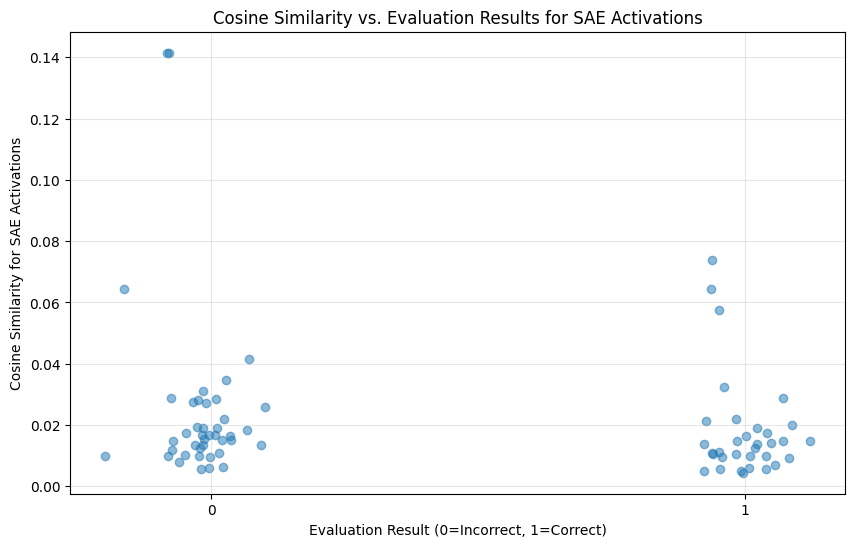


Statistics for cosine similarity for 0to60USMLE_pirate.jsonl:
Average similarity for correct answers: 0.0179
Average similarity for incorrect answers: 0.0247


In [16]:


# Create lists for plotting
x_values = []  # Will contain 0s and 1s from evaluations
y_values = []  # Will contain corresponding cosine similarities

# Process each row
for _, row in correct_df.iterrows():
    steered_evals = get_steered_evaluations(row['evaluation'])
    
    # Add steered0 data point
    x_values.append(steered_evals[0])
    
    # Choose appropriate column names based on settings
    if use_top_activations:
        steered0_col = 'cosine_sim_top_steered0'
        steered1_col = 'cosine_sim_top_steered1'
    else:
        steered0_col = 'cosine_sim_steered0'
        steered1_col = 'cosine_sim_steered1'
    
    y_values.append(row[steered0_col])
    
    # Add steered1 data point
    x_values.append(steered_evals[1])
    y_values.append(row[steered1_col])

# Convert x_values to numpy array of integers
x_values = np.array(x_values, dtype=int)

# Create scatter plot
plt.figure(figsize=(10, 6))

# Add some jitter to x-axis to better show distribution
x_jitter = np.random.normal(0, 0.05, len(x_values))
plt.scatter(x_values + x_jitter, y_values, alpha=0.5)

activation_type = "Top Activations" if use_top_activations else "SAE Activations"
plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
plt.ylabel(f'Cosine Similarity for {activation_type}')
plt.title(f'Cosine Similarity vs. Evaluation Results for {activation_type}')

# Set x-axis ticks to only show 0 and 1
plt.xticks([0, 1])

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show plot
plt.show()

# Print statistics
print(f"\nStatistics for cosine similarity for {file_name}:")
correct_similarities = [s for i, s in enumerate(y_values) if x_values[i] == 1]
incorrect_similarities = [s for i, s in enumerate(y_values) if x_values[i] == 0]
print(f"Average similarity for correct answers: {np.mean(correct_similarities):.4f}")
print(f"Average similarity for incorrect answers: {np.mean(incorrect_similarities):.4f}")

#### RESULTS: USMLE Dataset:
While it is a tiny bit more promising for the non-normalized results than the Manhattan distance, it's still does not look like a reliable indicator for model drift. The scatter plot does not show significant clustering

Readout for cos similariy for USMLE 0to60 pirate:

    Statistics for cosine similarity for 0to60USMLE_pirate.jsonl (norm=Yes, top=Yes)
    Average similarity for correct answers: 0.6531
    Average similarity for incorrect answers: 0.6996

    Statistics for cosine similarity for 0to60USMLE_pirate.jsonl: (norm=No, top=No)
    Average similarity for correct answers: 0.0179
    Average similarity for incorrect answers: 0.0247


## Dot Product 

In [17]:
def calculate_dot_product(vec1, vec2, bNormalize=False):
    """
    Calculate dot product between two vectors, with optional normalization.
    
    Args:
        vec1, vec2: Input vectors (lists or numpy arrays)
        bNormalize: If True, normalize vectors to [-1, 1] before calculating
    
    Returns:
        float: Dot product between the vectors
    """
    # Convert to numpy arrays and flatten
    vec1 = np.array(vec1).flatten()
    vec2 = np.array(vec2).flatten()
    
    if bNormalize:
        # Normalize vectors to [-1, 1]
        vec1_range = vec1.max() - vec1.min()
        vec1 = 2 * (vec1 - vec1.min()) / vec1_range - 1 if vec1_range != 0 else np.zeros_like(vec1)
        
        vec2_range = vec2.max() - vec2.min()
        vec2 = 2 * (vec2 - vec2.min()) / vec2_range - 1 if vec2_range != 0 else np.zeros_like(vec2)
    
    # Calculate dot product
    return np.dot(vec1, vec2)


In [18]:
use_normalized = True  # USE THE NORMALIZED OR NORMAL DOT PRODUCT

In [19]:
# Calculate dot products for all rows and add as new columns
# For SAE activations
correct_df['dot_prod_steered0'] = correct_df.apply(
    lambda row: calculate_dot_product(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered0'],
        bNormalize=use_normalized
    ),
    axis=1
)

correct_df['dot_prod_steered1'] = correct_df.apply(
    lambda row: calculate_dot_product(
        row['SAE_Activations_No_Steering'],
        row['SAE_Activations_Steered1'],
        bNormalize=use_normalized
    ),
    axis=1
)

# For Top activations
correct_df['dot_prod_top_steered0'] = correct_df.apply(
    lambda row: calculate_dot_product(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered0'],
        bNormalize=use_normalized
    ),
    axis=1
)

correct_df['dot_prod_top_steered1'] = correct_df.apply(
    lambda row: calculate_dot_product(
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered1'],
        bNormalize=use_normalized
    ),
    axis=1
)

# Print first few results to verify
print("\nFirst few Dot products for SAE activations:")
print(correct_df[['dot_prod_steered0', 'dot_prod_steered1']].head())
print("\nFirst few Dot products for Top activations:")
print(correct_df[['dot_prod_top_steered0', 'dot_prod_top_steered1']].head())



First few Dot products for SAE activations:
   dot_prod_steered0  dot_prod_steered1
0      130931.260327      130939.704717
1      130852.003426      130926.009056
2      130784.725624      131004.066933
3      130890.144479      130980.964644
4      131002.265098      130828.016877

First few Dot products for Top activations:
   dot_prod_top_steered0  dot_prod_top_steered1
0               7.694561               9.299312
1               9.396688               7.775807
2               8.994624              10.220256
3               7.693340              10.879715
4               9.203862               9.841067


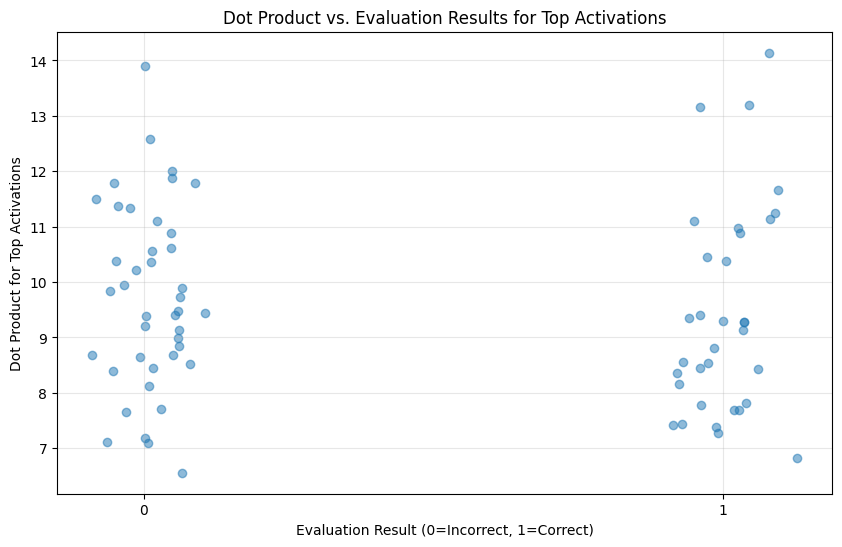


Statistics for dot products in 0to60USMLE_pirate.jsonl:
Average dot product for correct answers (normalized=True, top_only=True): 9.4140
Average dot product for incorrect answers (normalized=True, top_only=True): 9.7167


In [20]:

# Visualization

use_top_activations = True  # Whether to use top 10 SAE activations instead of all SAE activations

# Create lists for plotting
x_values = []  # Will contain 0s and 1s from evaluations
y_values = []  # Will contain corresponding dot products

# Process each row
for _, row in correct_df.iterrows():
    steered_evals = get_steered_evaluations(row['evaluation'])
    
    # Add steered0 data point
    x_values.append(steered_evals[0])
    
    # Choose appropriate column names based on settings
    if use_top_activations:
        steered0_col = 'dot_prod_top_steered0'
        steered1_col = 'dot_prod_top_steered1'
    else:
        steered0_col = 'dot_prod_steered0'
        steered1_col = 'dot_prod_steered1'
    
    y_values.append(row[steered0_col])
    
    # Add steered1 data point
    x_values.append(steered_evals[1])
    y_values.append(row[steered1_col])

# Convert x_values to numpy array of integers
x_values = np.array(x_values, dtype=int)

# Create scatter plot
plt.figure(figsize=(10, 6))

# Add some jitter to x-axis to better show distribution
x_jitter = np.random.normal(0, 0.05, len(x_values))
plt.scatter(x_values + x_jitter, y_values, alpha=0.5)

activation_type = "Top Activations" if use_top_activations else "SAE Activations"
plt.xlabel('Evaluation Result (0=Incorrect, 1=Correct)')
plt.ylabel(f'Dot Product for {activation_type}')
plt.title(f'Dot Product vs. Evaluation Results for {activation_type}')

# Set x-axis ticks to only show 0 and 1
plt.xticks([0, 1])

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show plot
plt.show()

# Print statistics
print(f"\nStatistics for dot products in {file_name}:")
correct_dots = [d for i, d in enumerate(y_values) if x_values[i] == 1]
incorrect_dots = [d for i, d in enumerate(y_values) if x_values[i] == 0]
print(f"Average dot product for correct answers (normalized={use_normalized}, top_only={use_top_activations}): {np.mean(correct_dots):.4f}")
print(f"Average dot product for incorrect answers (normalized={use_normalized}, top_only={use_top_activations}): {np.mean(incorrect_dots):.4f}")

#### Results for 0to60 USMLE pirate:

Not really any clustering. Dot product is arguably a bit higher for incorrect answers?

readout: 

    Statistics for dot products in 0to60USMLE_pirate.jsonl:
    Average dot product for correct answers (normalized=True, top_only=True): 37910031647.0103
    Average dot product for incorrect answers (normalized=True, top_only=True): 42515503387.0656

    Statistics for dot products in 0to60USMLE_pirate.jsonl:
    Average dot product for correct answers (normalized=False, top_only=False): 233.1198
    Average dot product for incorrect answers (normalized=False, top_only=False): 314.8

## Top latent and overlapping latent analysis for individual prompts

took code from LetsDriftGemma2_Hooked_continued.ipynb

## define row numer

In [21]:
row_num = 0
import plotly.express as px

In [22]:
#row = correct_df['Top_Activations_No_Steering'].iloc[row_number]

In [23]:
#print(row)

## Define a bunch of plotting functions

In [24]:
def plot_activations_comparison(df, row_number):
    """
    Create a bar plot comparing top activations between unsteered and steered responses.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
    """
    import plotly.express as px
    import plotly.graph_objects as go
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Create figure
    fig = go.Figure()
    
    # Process and add traces for each set of activations
    for name, activations, color in [
        ("No Steering", row['Top_Activations_No_Steering'], '#1f77b4'),
        ("Steered 0", row['Top_Activations_Steered0'], '#ff7f0e'),
        ("Steered 1", row['Top_Activations_Steered1'], '#ff7f0e') # for a different colour: 2ca02c
    ]:
        # Extract indices and values
        indices = [pair[0] for pair in activations]
        values = [pair[1] for pair in activations]
        
        # Add bar plot
        fig.add_trace(go.Bar(
            x=indices,
            y=values,
            name=name,
            marker_color=color,
            width=100  # Adjust bar width as needed
        ))
    
    # Update layout
    fig.update_layout(
        title=f"Top Latent Activations Comparison (Row {row_number})",
        xaxis_title="Latent Index",
        yaxis_title="Activation Value",
        width=1000,
        showlegend=True,
        barmode='group'  # Group bars for each latent index
    )
    
    # Show the plot
    fig.show()
    
    # Print evaluation results
    print(f"\nEvaluation results: {row['evaluation']}")
    
    # Print top 3 activations for each
    print("\nTop 3 activations for each generation:")
    for name, activations in [
        ("No Steering", row['Top_Activations_No_Steering']),
        ("Steered 0", row['Top_Activations_Steered0']),
        ("Steered 1", row['Top_Activations_Steered1'])
    ]:
        print(f"\n{name}:")
        for idx, val in activations[:3]:  # Take first 3 pairs
            print(f"Latent {idx} had activation {val:.2f}")

In [25]:
def plot_activations_comparison_v2(df, row_number):
    """
    Create a bar plot comparing top activations between unsteered and steered responses.
    Only shows latent indices with non-zero activation values.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
    """
    import plotly.graph_objects as go
    
    # Get the row data
    row = df.iloc[row_number]
    
    # Create figure
    fig = go.Figure()
    
    # Collect all unique indices with non-zero activations
    all_indices = set()
    for activations in [
        row['Top_Activations_No_Steering'],
        row['Top_Activations_Steered0'],
        row['Top_Activations_Steered1']
    ]:
        indices = [pair[0] for pair in activations if pair[1] > 0]
        all_indices.update(indices)
    
    # Sort indices for consistent x-axis
    all_indices = sorted(list(all_indices))
    
    # Process and add traces for each set of activations
    for name, activations, color in [
        ("No Steering", row['Top_Activations_No_Steering'], '#1f77b4'),
        ("Steered 0", row['Top_Activations_Steered0'], '#ff7f0e'),
        ("Steered 1", row['Top_Activations_Steered1'], '#FF550E') #2ca02c
    ]:
        # Create a dictionary for quick lookup of values by index
        act_dict = {idx: val for idx, val in activations if val > 0}
        
        # Get values for all indices (0 if not present)
        values = [act_dict.get(idx, 0) for idx in all_indices]
        
        # Add bar plot
        fig.add_trace(go.Bar(
            x=[str(idx) for idx in all_indices],  # Convert indices to strings
            y=values,
            name=name,
            marker_color=color,
            width=0.2  # Adjust bar width as needed
        ))
    
    # Update layout
    fig.update_layout(
        title=f"Top Latent Activations Comparison (Row {row_number})",
        xaxis_title="Latent Index",
        yaxis_title="Activation Value",
        width=1000,
        showlegend=True,
        barmode='group',  # Group bars for each latent index
        xaxis=dict(
            tickangle=45,  # Angle the tick labels for better readability
            type='category'  # Treat x-axis as categorical
        )
    )
    
    # Show the plot
    fig.show()
    
    # Print evaluation results
    print(f"\nEvaluation results: {row['evaluation']}")
    
    # Print top 3 activations for each
    print("\nTop 3 activations for each generation:")
    for name, activations in [
        ("No Steering", row['Top_Activations_No_Steering']),
        ("Steered 0", row['Top_Activations_Steered0']),
        ("Steered 1", row['Top_Activations_Steered1'])
    ]:
        print(f"\n{name}:")
        for idx, val in activations[:3]:  # Take first 3 pairs
            print(f"Latent {idx} had activation {val:.2f}")

In [39]:
def plot_activations_comparison_with_sae(df, row_number):
    """
    Create a bar plot comparing top unsteered activations with their corresponding 
    values in the full SAE activations of steered responses.
    
    Args:
        df: DataFrame containing the activation data
        row_number: Index of the row to analyze
    """
    import plotly.graph_objects as go
    from ipywidgets import Button, Output, VBox
    import IPython.display as display
    
    # Create button and output widgets
    next_button = Button(description='Next Row')
    output = Output()
    
    def plot_data(row_num):
        with output:
            output.clear_output()
            # Get the row data
            row = df.iloc[row_num]
            
            # Create figure
            fig = go.Figure()
            
            # Get indices and values from unsteered top activations
            unsteered_indices = [pair[0] for pair in row['Top_Activations_No_Steering']]
            unsteered_values = [pair[1] for pair in row['Top_Activations_No_Steering']]
            
            # First, add unsteered top activations
            fig.add_trace(go.Bar(
                x=[str(idx) for idx in unsteered_indices],
                y=unsteered_values,
                name="No Steering (Top)",
                marker_color='#1f77b4',
                width=0.2
            ))
            
            # Add corresponding values from steered SAE activations
            for name, activations, color in [
                ("Steered 0 (SAE)", row['SAE_Activations_Steered0'][0], '#ff7f0e'),
                ("Steered 1 (SAE)", row['SAE_Activations_Steered1'][0], '#2ca02c')
            ]:
                # Extract values for the same indices as unsteered top activations
                values = []
                for idx in unsteered_indices:
                    try:
                        values.append(activations[idx])
                    except IndexError:
                        print(f"Warning: Index {idx} not found in {name}")
                        values.append(0)
                
                fig.add_trace(go.Bar(
                    x=[str(idx) for idx in unsteered_indices],
                    y=values,
                    name=name,
                    marker_color=color,
                    width=0.2
                ))
            
            # Update layout
            fig.update_layout(
                title=f"Top Unsteered Latents vs Corresponding SAE Values (Row {row_num})",
                xaxis_title="Latent Index",
                yaxis_title="Activation Value",
                width=1000,
                showlegend=True,
                barmode='group',
                xaxis=dict(
                    tickangle=45,
                    type='category'
                )
            )
            
            # Show the plot
            fig.show()
            
            # Print evaluation results
            print(f"\nEvaluation results: {row['evaluation']}")
            
            # Print values for each latent
            print("\nActivation values for each latent:")
            for i, idx in enumerate(unsteered_indices):
                print(f"\nLatent {idx}:")
                print(f"  No Steering (Top): {unsteered_values[i]:.2f}")
                try:
                    print(f"  Steered 0 (SAE): {row['SAE_Activations_Steered0'][0][idx]:.2f}")
                    print(f"  Steered 1 (SAE): {row['SAE_Activations_Steered1'][0][idx]:.2f}")
                except IndexError:
                    print(f"  Warning: Index {idx} not found in SAE activations")
    
    # Initial plot
    plot_data(row_number)
    
    # Button click handler
    def on_button_clicked(b):
        nonlocal row_number
        row_number += 1
        if row_number < len(df):
            plot_data(row_number)
        else:
            with output:
                print("Reached the end of the DataFrame")
                row_number = len(df) - 1
    
    next_button.on_click(on_button_clicked)
    
    # Display button and output
    display.display(VBox([next_button, output]))

### Result1: Complete overview (quite useless with 131k features, hard to recognize anyhting..)

In [33]:
plot_activations_comparison(correct_df, row_num)  


Evaluation results: ['1', '1', '1']

Top 3 activations for each generation:

No Steering:
Latent 122122 had activation 31.63
Latent 51512 had activation 26.20
Latent 34860 had activation 21.86

Steered 0:
Latent 29917 had activation 95.22
Latent 118947 had activation 34.92
Latent 114196 had activation 31.92

Steered 1:
Latent 29917 had activation 95.01
Latent 83902 had activation 46.10
Latent 120222 had activation 24.64


### Result 2: Reduced x-axis to relevant data

In [34]:
plot_activations_comparison_v2(correct_df, row_num)  # Replace 0 with any row number you want to analyze


Evaluation results: ['1', '1', '1']

Top 3 activations for each generation:

No Steering:
Latent 122122 had activation 31.63
Latent 51512 had activation 26.20
Latent 34860 had activation 21.86

Steered 0:
Latent 29917 had activation 95.22
Latent 118947 had activation 34.92
Latent 114196 had activation 31.92

Steered 1:
Latent 29917 had activation 95.01
Latent 83902 had activation 46.10
Latent 120222 had activation 24.64


#### Result 2a: the top latents are super different, even though the unsteered answers were also correct!
Evaluation results: ['1', '1', '1']

Top 3 activations for each generation:

No Steering:
Latent 122122 had activation 31.63
Latent 51512 had activation 26.20
Latent 34860 had activation 21.86

Steered 0:
Latent 29917 had activation 95.22
Latent 118947 had activation 34.92
Latent 114196 had activation 31.92

Steered 1:
Latent 29917 had activation 95.01
Latent 83902 had activation 46.10
Latent 120222 had activation 24.64
#### **THOUGHT: Perhaps the answer is not determined by this layers' Latents' activations...!**

## Result 3: Comparing the Top Latents of unsteered answer with their steered answer's corresponding latents:

In [41]:
plot_activations_comparison_with_sae(correct_df, 0)  # Replace 0 with any row number you want to analyze

In [38]:
#SANITY CHECK -- manually read out the activation value of a latent of a certain row
row = correct_df.iloc[0]
print(f"Activation value for latent 105608 in Steered0: {row['SAE_Activations_Steered1'][0][105608]}")


Activation value for latent 105608 in Steered0: 0.0
